In [22]:
from tensorflow.keras.utils import image_dataset_from_directory


In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1


In [24]:
data = r'C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1\data'
import tensorflow as tf
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42
)

class_names = train_ds_raw.class_names

print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)



Found 4188 files belonging to 4 classes.
Using 2932 files for training.
Found 4188 files belonging to 4 classes.
Using 1256 files for validation.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


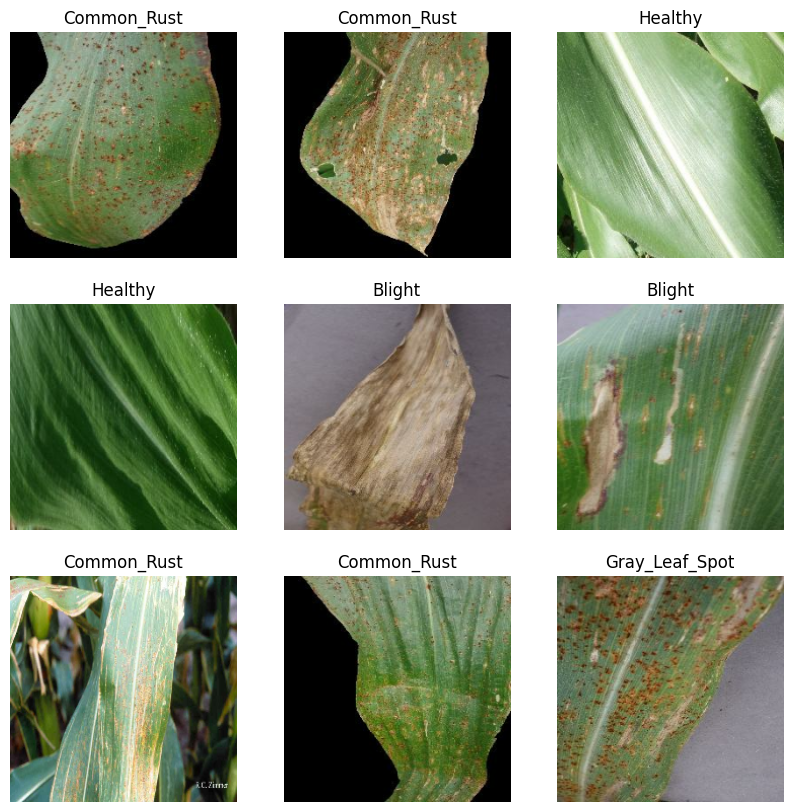

In [25]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training


In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=6)


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 664ms/step - accuracy: 0.8779 - loss: 0.3248 - val_accuracy: 0.9108 - val_loss: 0.2221
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 625ms/step - accuracy: 0.9345 - loss: 0.1682 - val_accuracy: 0.9252 - val_loss: 0.1991
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 604ms/step - accuracy: 0.9553 - loss: 0.1174 - val_accuracy: 0.9220 - val_loss: 0.2060
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 616ms/step - accuracy: 0.9662 - loss: 0.0953 - val_accuracy: 0.9108 - val_loss: 0.2387
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 612ms/step - accuracy: 0.9731 - loss: 0.0720 - val_accuracy: 0.9196 - val_loss: 0.2400
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 582ms/step - accuracy: 0.9799 - loss: 0.0547 - val_accuracy: 0.9260 - val_loss: 0.2182
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 647ms/step - accuracy: 0.9870 - loss: 0.0426 - val_accuracy: 0.9204 - val_loss: 0.2343
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 632ms/step - accuracy: 0.9925 - loss: 0.0299 - val_accu

In [29]:
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# If one-hot encoded labels:
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
# Optional: confusion matrix
print(confusion_matrix(y_true, y_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step
                precision    recall  f1-score   support

        Blight       0.88      0.86      0.87       339
   Common_Rust       0.96      0.96      0.96       383
Gray_Leaf_Spot       0.78      0.82      0.80       183
       Healthy       0.99      0.99      0.99       351

      accuracy                           0.92      1256
     macro avg       0.90      0.91      0.91      1256
  weighted avg       0.92      0.92      0.92      1256

[[290  10  37   2]
 [  9 369   5   0]
 [ 27   6 150   0]
 [  2   0   0 349]]
